# requirements

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf
import keras 
# from tensorflow import keras
from keras.layers import Input,Dense 
from keras.models import Model,Sequential
from keras.optimizers import Adam
from keras.optimizers import SGD,Adam
from keras.regularizers import l2
from keras.metrics import RootMeanSquaredError
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping,ModelCheckpoint,TerminateOnNaN
from keras import backend as K
print(tf.__version__)

2.4.1


In [3]:
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Sklearn
import kerastuner as kt

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE

In [5]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [6]:
from tqdm import tqdm_notebook as tn 

In [7]:
import itertools

In [8]:
plt.rcParams["figure.figsize"] = [20, 10] 
plt.rcParams["axes.grid"]=True
plt.rcParams["font.size"]=16

# report function

In [9]:
def regression_report(y_true,y_pred):
    print(f"""
    MSE:     {metrics.mean_squared_error(y_true,y_pred)}
    RMSE:    {metrics.mean_squared_error(y_true,y_pred,squared=False)}
    MAE      {metrics.median_absolute_error(y_true,y_pred)}
    R2:      {metrics.r2_score(y_true,y_pred)}""")

# generated data 

In [10]:
X_data = np . linspace (-1 , 1 , 100)
num_coef=5
coef =[ 10, 2 , 30 , 4 , 5 ]
y_data=0
for i in range(num_coef):
    y_data += coef[i]*np.power(X_data,i)
    y_data += np.random.randn(*X_data.shape)*1.5

In [11]:
X_data = X_data.reshape(-1,1)
y_data = y_data.reshape(-1,1)

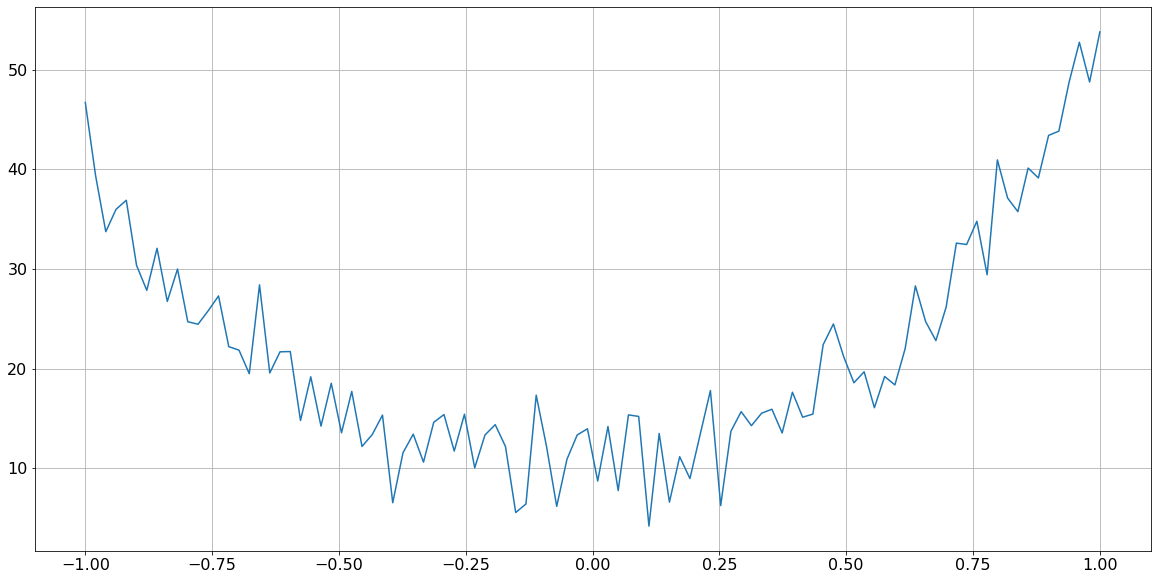

In [12]:
plt.plot(X_data,y_data);

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X_data,
                                                 y_data,
                                                 test_size=0.2,
                                                 random_state=0)

Let's take n=3 as max degree of polynomial regression

In [14]:
n = 3

## Sklearn

Спробуємо спершу Sklearn щоб оцінити результат за різних бібліотек 

In [15]:
sklearn_pipeline=Pipeline([
    ("poly_features",PolynomialFeatures(n+1)),
    ("scaler",StandardScaler()),
    ("lr",LinearRegression())
])

In [16]:
sklearn_pipeline.fit(X_train,y_train)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=4)),
                ('scaler', StandardScaler()), ('lr', LinearRegression())])

In [17]:
y_pred = sklearn_pipeline.predict(X_data)

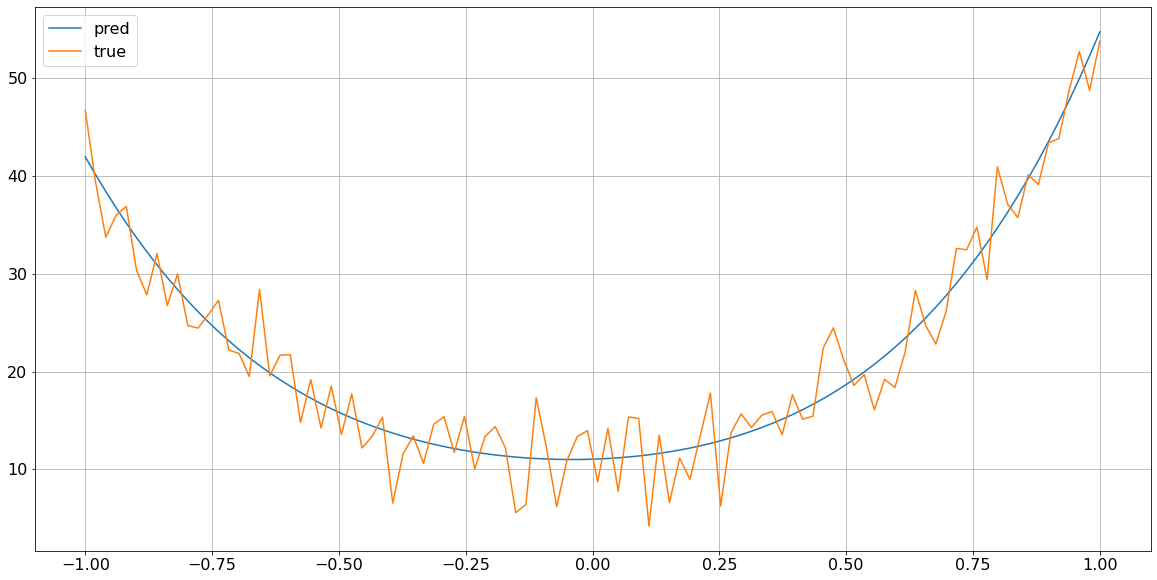

In [18]:
plt.plot(X_data,y_pred,label="pred")
plt.plot(X_data,y_data,label="true")
plt.legend();

In [19]:
regression_report(y_test,sklearn_pipeline.predict(X_test))


    MSE:     13.279020506275046
    RMSE:    3.644039037424688
    MAE      2.418770592445483
    R2:      0.8853754869651201


## Keras

Тепер спробуємо отримати той самий результат за допомогою фреймворку Keras. Так як дані прості, поки що можна не зберегати моделі. Але для наступного датасету зберігання буде виконано, оскільки дані там набагато більшої розмірності

In [20]:
# Apply Polynomial features first
X_train_poly = PolynomialFeatures(3).fit_transform(X_train)
X_test_poly = PolynomialFeatures(3).fit_transform(X_test)
X_data_poly = PolynomialFeatures(3).fit_transform(X_data)

# Apply standard scaling (train.mean & train.std for test too)
scaler = StandardScaler().fit(X_train_poly)
X_train_poly_scaled = scaler.transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)
X_data_poly_scaled = scaler.transform(X_data_poly)

In [21]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [32]:
def build_model(hp):
    model = Sequential([
        Dense(1,input_shape=(4,),
              activation="linear",
              kernel_initializer='ones',
              kernel_regularizer=tf.keras.regularizers.L2(
                  l2=hp.Choice("regularization_parameter",
                               values=[0.01,0.1,1.0])))
    ])
    
    model.compile(loss="mean_squared_error",
                  optimizer=tf.keras.optimizers.SGD(
                              learning_rate=hp.Float('learning_rate',
                                                     1e-4,1e-1),
                              momentum=hp.Choice('momentum',
                                     values = [0.0,0.5,0.9,0.99])),
                  metrics=["mae",root_mean_squared_error,
                           'mean_squared_logarithmic_error'])
    return model

In [33]:
hp = kt.HyperParameters()

In [36]:
# tuner = kt.Hyperband(build_model,
#                         objective='val_loss',
#                         seed=0,
#                         max_epochs=100,
#                         directory='generated_data_dir')
tuner = kt.RandomSearch(build_model,
                        objective='val_loss',
                        seed=0,
                        max_trials=5,
                        directory='generated_data_rand_dir')

In [37]:
tuner.search(X_train_poly_scaled,
             y_train,
             epochs=100,
             validation_split=0.2,
             callbacks=[ModelCheckpoint('generated_data_best_model.h5',
                                        monitor='val_loss',
                                        mode="min",
                                        save_best_only=True,
                                        verbose=1),
                        EarlyStopping(monitor='val_loss',
                           mode="min",
                           verbose=1,
                           min_delta=0.1,
                           patience=5),
                        TerminateOnNaN(),
                        keras.callbacks.History(),
                        keras.callbacks.TensorBoard(log_dir='./logs/fit/gendata_rands')
                       ])

Trial 5 Complete [00h 00m 04s]
val_loss: 19.922447204589844

Best val_loss So Far: 11.719125747680664
Total elapsed time: 00h 00m 18s
INFO:tensorflow:Oracle triggered exit


In [29]:
best_model =  tuner.get_best_models()[0]

In [140]:
tuner.results_summary()

Results summary
Results in generated_data_dir\untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
regularization_parameter: 0.011445430252991029
learning_rate: 0.05661514512697152
momentum: 0.99
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: 7c0c65b0459981f24a69805acf939433
Score: 11.595061302185059
Trial summary
Hyperparameters:
regularization_parameter: 0.011445430252991029
learning_rate: 0.05661514512697152
momentum: 0.99
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 4
tuner/round: 1
tuner/trial_id: 0b7fb12171d1e75462e69e3fdad6ef86
Score: 11.977730751037598
Trial summary
Hyperparameters:
regularization_parameter: 0.015924368015884746
learning_rate: 0.09081633063996458
momentum: 0.0
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 50497aa0abf76bed1fe3067533a66d80
Score: 12.278642654418945
Trial summary
Hyperparameters:
regularizatio

In [41]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [46]:
%reload_ext tensorboard

kill: 12032: No such process


In [47]:
%tensorboard --logdir='logs\fit\gendata_rands\'

Reusing TensorBoard on port 6006 (pid 12032), started 0:06:27 ago. (Use '!kill 12032' to kill it.)

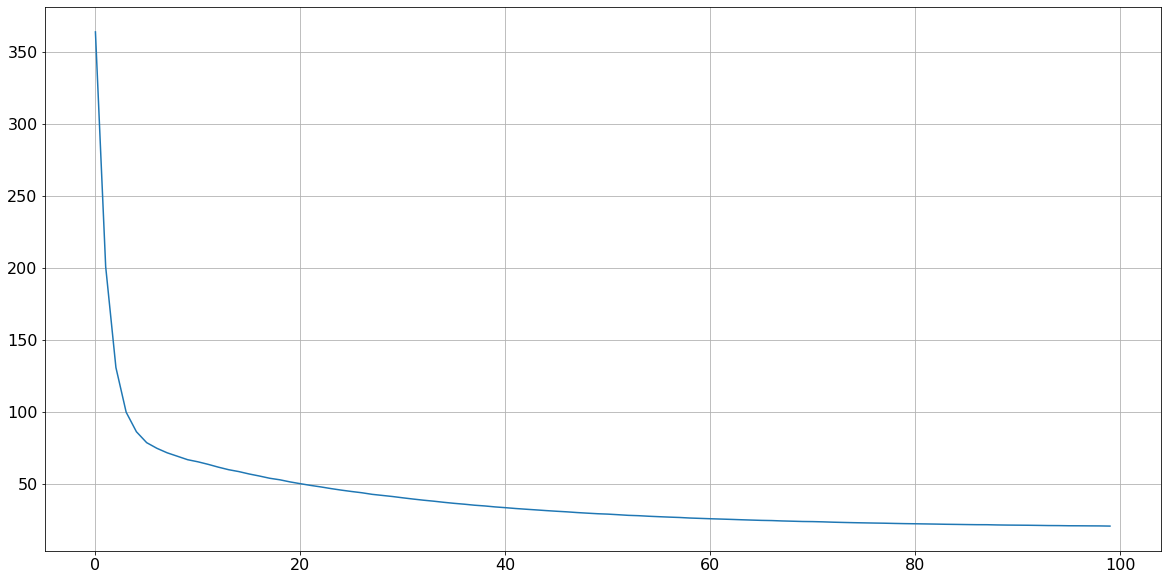

In [22]:
plt.plot(history.history["loss"])

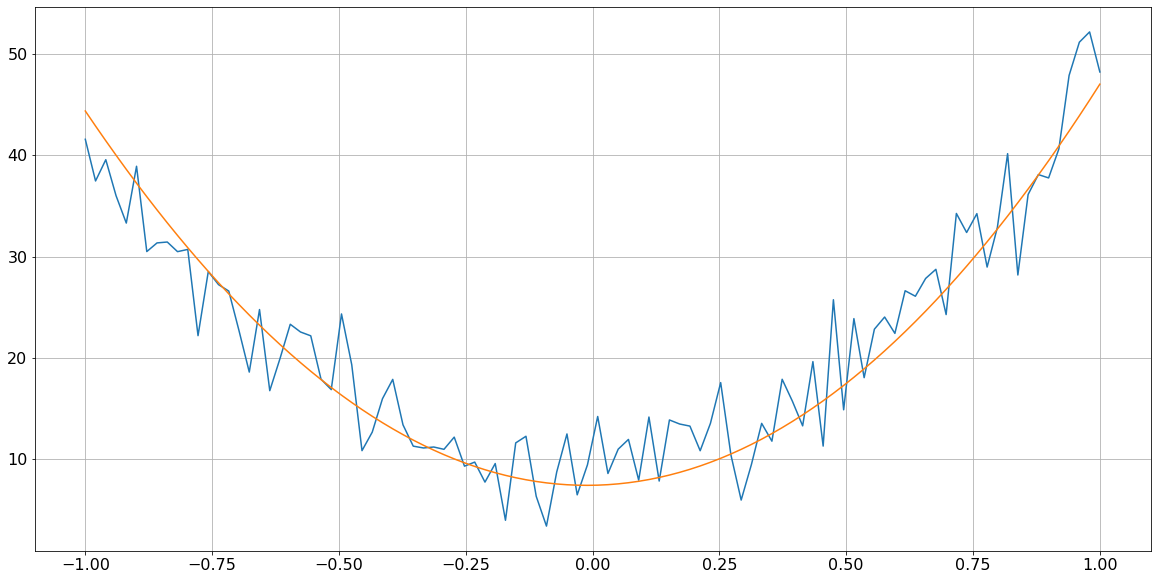

In [142]:
plt.plot(X_data,y_data)
plt.plot(X_data,best_model.predict(X_data_poly_scaled))

In [143]:
regression_report(y_test,best_model.predict(X_test_poly_scaled))


    MSE:     14.853738536349923
    LogMSE:  0.04743256595734484
    RMSE:    3.8540548175071305
    MAE      3.2902590256680746
    R2:      0.8402810001504369


Comparing to sklearn

In [144]:
regression_report(y_test,sklearn_pipeline.predict(X_test))


    MSE:     11.046123196999039
    LogMSE:  0.029763741076264272
    RMSE:    3.3235708503052916
    MAE      2.5166961007565103
    R2:      0.881223454625768


# california housing

In [145]:
california_housing_data = fetch_california_housing(download_if_missing=True)

In [146]:
print(california_housing_data["DESCR"])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [167]:
X = california_housing_data["data"]
y = california_housing_data["target"]

In [169]:
X.shape,y.shape

((20640, 8), (20640,))

In [ ]:
y = y.reshape(-1,1)

In [180]:
data = np.concatenate([X,y],axis=1)

In [181]:
data_scaled = StandardScaler().fit_transform(data)

In [182]:
data_scaled_tsne_3d = TSNE(3,
                           n_jobs=-1).fit_transform(data_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20640 samples in 0.071s...
[t-SNE] Computed neighbors for 20640 samples in 3.537s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20640
[t-SNE] Computed conditional probabilities for sample 2000 / 20640
[t-SNE] Computed conditional probabilities for sample 3000 / 20640
[t-SNE] Computed conditional probabilities for sample 4000 / 20640
[t-SNE] Computed conditional probabilities for sample 5000 / 20640
[t-SNE] Computed conditional probabilities for sample 6000 / 20640
[t-SNE] Computed conditional probabilities for sample 7000 / 20640
[t-SNE] Computed conditional probabilities for sample 8000 / 20640
[t-SNE] Computed conditional probabilities for sample 9000 / 20640
[t-SNE] Computed conditional probabilities for sample 10000 / 20640
[t-SNE] Computed conditional probabilities for sample 11000 / 20640
[t-SNE] Computed conditional probabilities for sample 12000 / 20640
[t-SNE] Computed conditional probabilities for sam

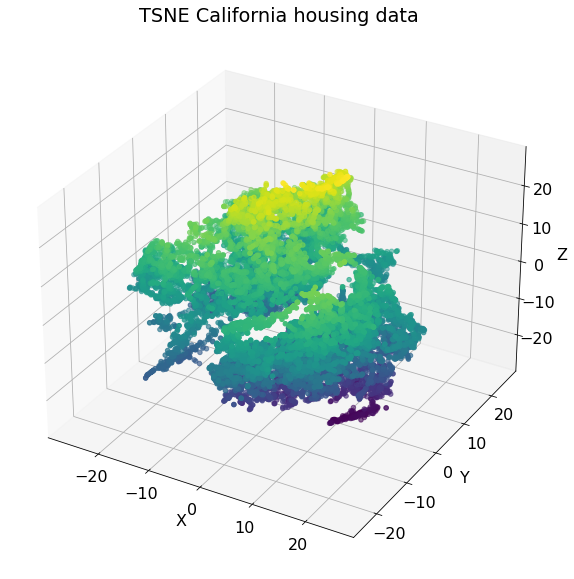

In [185]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_scaled_tsne_3d[:,0],
           data_scaled_tsne_3d[:,1],
           data_scaled_tsne_3d[:,2],
           c=data_scaled_tsne_3d[:,2],
           marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("TSNE California housing data")
plt.show()

In [205]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [206]:
X_train.shape,y_train.shape

((15480, 8), (15480,))

In [237]:
# Apply Polynomial features first
X_train_poly = PolynomialFeatures(3).fit_transform(X_train)
X_test_poly = PolynomialFeatures(3).fit_transform(X_test)

# Apply standard scaling (train.mean & train.std for test too)
scaler = StandardScaler().fit(X_train_poly)
X_train_poly_scaled = scaler.transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

In [247]:
def build_model(hp):
    model = Sequential([
        Dense(1,input_shape=(165,),
              activation="linear",
              kernel_initializer='ones',
              kernel_regularizer=tf.keras.regularizers.L2(
                  l2=hp.Choice("regularization_parameter",[0.01,1.0])))
    ])
    
    model.compile(loss="mean_squared_error",
                  optimizer=tf.keras.optimizers.SGD(
                              learning_rate=hp.Choice('learning_rate',
                                                      values = [1e-3,1e-2,1e-1]),
                              momentum=hp.Choice('momentum',
                                     values = [0.0,0.5,0.9,0.99])),
                  metrics=["mae",root_mean_squared_error,
                           'mean_squared_logarithmic_error'])
    return model

In [248]:
mc = ModelCheckpoint('california_best_model.h5',
                     monitor='val_loss',
                     mode="min",
                     save_best_only=True,
                     verbose=1)
es_patient = EarlyStopping(monitor='val_loss',
                           mode="min",
                           verbose=1,
                           min_delta=0.1,
                           patience=5)
nan_t = TerminateOnNaN()

In [252]:
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=100,
                     directory='house_data_dir/')

In [253]:
tuner.search(X_train_poly_scaled,
             y_train,
             validation_split=0.2,
             callbacks=[mc,es_patient,nan_t,
                        tf.keras.callbacks.TensorBoard('house_tb')])

Trial 24 Complete [00h 00m 03s]
val_loss: inf

Best val_loss So Far: 9386.9423828125
Total elapsed time: 00h 01m 36s
INFO:tensorflow:Oracle triggered exit


In [272]:
%tensorboard --logdir house_tb/

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 21300.

In [254]:
best_model = tuner.get_best_models()[0]

In [256]:
y_pred = best_model.predict(X_test_poly_scaled)

In [261]:
regression_report(y_test,y_pred)


    MSE:     122023.03025619552
    RMSE:    349.3179500915971
    MAE      7.160840187072754
    R2:      -92311.26680103065


## sklearn and XGBoost

In [263]:
xgb = XGBRegressor(n_estimators=100,max_depth=5,n_jobs=-1)
xgb.fit(X_train_poly_scaled,y_train)
y_pred_test_xgb = xgb.predict(X_test_poly_scaled)

In [264]:
regression_report(y_test,y_pred_test_xgb)


    MSE:     0.22378537267207338
    RMSE:    0.47305958680918136
    MAE      0.211212895154953
    R2:      0.8307029829951004


In [266]:
random_forest_regressor = RandomForestRegressor(n_jobs=-1,random_state=0)
random_forest_regressor.fit(X_train_poly_scaled,y_train)
y_pred_test = random_forest_regressor.predict(X_test_poly_scaled)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s


building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.2s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.0s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.8s


building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.8s


building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   40.2s


building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   47.7s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   57.2s


building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.1min


building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  1.3min remaining:    3.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [267]:
regression_report(y_test,y_pred_test)


    MSE:     0.2835047459480739
    RMSE:    0.5324516371916551
    MAE      0.22388499999999967
    R2:      0.7855243744367819
